In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
# We need to join the upper directory in order to access the local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy import stats

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [7]:
from pytdoa.mlat import exact, lls, nlls
from pytdoa.pytdoa import brutefoptim, nonlinoptim, linoptim
from pytdoa.util import generate_heatmap, generate_hyperbola
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

In [6]:
fs = 92.16e6
cij_meas = np.array([21.64, 14.84, 6.79])
cij_meters = cij_meas/(fs * 16) * SPEED_OF_LIGHT # 16 is the oversample used to calculate this offset

In [7]:
description = pd.read_csv('tdoa_5g_loc/description.csv')

In [8]:
def process_positions(filename):
    # gNB and UE parsing
    with open(filename) as f:
        setup_string = f.readlines()

    for line in setup_string:
        elem = line.split(" ")

        if elem[0] == 'gnb0':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            gnb0 = [float(posxy[0]),float(posxy[1])]
        elif elem[0] == 'gnb1':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            gnb1 = [float(posxy[0]),float(posxy[1])]
        elif elem[0] == 'gnb2':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            gnb2 = [float(posxy[0]),float(posxy[1])]
        elif elem[0] == 'ue':
            posxy = elem[1].replace('(','').replace(')','').replace('\n','').split(",")
            ue = [float(posxy[0]),float(posxy[1])]

    # Offset calculation
    gnb = np.vstack((gnb0,gnb1,gnb2))
    ue = np.array(ue)

    return (gnb, ue)

## Experiments 14-17

In [17]:
description_other = description.iloc[13:,:].sort_values(by='Time')
description_other = description_other.loc[description_other['Repetitions'] == 4,:]
description_other.head(5)

,Number,Oversampling,Repetitions,Day,Time
18,14,16,4,22,12:07
15,14,16,4,22,12:24
14,14,8,4,22,12:25
13,14,1,4,22,12:27
19,15,1,4,22,12:41


In [18]:
ddoa_df = pd.DataFrame(columns=['ddoa12','ddoa13','ddoa23','exp','oversample','uex','uey','gnb1x','gnb1y','gnb2x','gnb2y','gnb3x','gnb3y','c12','c13','c23'])

N = 30
visited = {}
for (idx,row) in description_other.iterrows():
    experiment = row['Number']

    # We get the positions for gNBs and UE directly from the experiment number
    (gnb, ue) = process_positions(f'{os.getcwd()}{os.sep}tdoa_5g_loc/setup/exp{experiment}/note.txt')

    # The TOA data is a bit trickier
    oversample = row['Oversampling']
    repetitions = row['Repetitions']

    # Be careful with duplicate experiments
    if visited.get(f'{experiment}{oversample}{repetitions}',0) == 0:
        data_filename = f'tdoa_5g_loc/setup/exp{experiment}/os{oversample}/prs_rx_{experiment}'
        visited[f'{experiment}{oversample}{repetitions}'] = 1
    else:
        data_filename = f'tdoa_5g_loc/setup/exp{experiment}/os{oversample}/prs_rx_{experiment}_2'

    columns = ['0','gnb','1','toa','2','3','4','5','6']

    # TOA file parsing
    toa = pd.read_csv(data_filename, names=columns, sep="s+|;|:|,", header=None, engine='python')
    toa = toa[['gnb','toa']]

    toa_0 = toa.loc[toa['gnb'] == 0,:]['toa'].to_numpy()
    toa_1 = toa.loc[toa['gnb'] == 1,:]['toa'].to_numpy()
    toa_2 = toa.loc[toa['gnb'] == 2,:]['toa'].to_numpy()

    min_size = np.min([3000, toa_0.shape[0], toa_1.shape[0], toa_2.shape[0]])
    toa_a = np.array([toa_0[0:min_size], toa_1[0:min_size], toa_2[0:min_size]], dtype=float)
    toa_av = uniform_filter1d(toa_a, size=N, mode='wrap', axis=1)
    tdoa_a = np.array([toa_av[0,:] - toa_av[1,:], toa_av[0,:] - toa_av[2,:], toa_av[1,:] - toa_av[2,:]])
    ddoa_a = (tdoa_a / (fs * oversample) * SPEED_OF_LIGHT)

    # Let's try and remove absurd values
    d12 = np.sqrt(np.sum(np.square(gnb[0,:] - gnb[1,:])))
    i12 = np.abs(ddoa_a[0,:]) < d12

    d13 = np.sqrt(np.sum(np.square(gnb[0,:] - gnb[2,:])))
    i13 = np.abs(ddoa_a[1,:]) < d13

    d23 = np.sqrt(np.sum(np.square(gnb[1,:] - gnb[2,:])))
    i23 = np.abs(ddoa_a[2,:]) < d23

    idx = i12 & i13 & i23
    ddoa_a = ddoa_a[:,idx]

    # Theoretical DDOA
    doa_th = np.sqrt(np.sum(np.square(ue - gnb), axis=1))
    ddoa_th = np.array([doa_th[0]-doa_th[1], doa_th[0]-doa_th[2], doa_th[1]-doa_th[2]])
    cij_mts = (ddoa_a - ddoa_th.reshape(-1,1)).T
    cij_mean = np.mean(cij_mts,axis=1)

    ddoa_m = ddoa_a + cij_mean

    tmp = pd.DataFrame(ddoa_m.T, columns=['ddoa12','ddoa13','ddoa23'])
    tmp['exp'] = row['Time']
    tmp['oversample'] = oversample
    tmp[['uex','uey']] = np.repeat(ue.reshape(1,-1),tmp.shape[0],axis=0)
    tmp[['gnb1x','gnb1y']] = np.repeat(gnb[0,:].reshape(1,-1),tmp.shape[0],axis=0)
    tmp[['gnb2x','gnb2y']] = np.repeat(gnb[1,:].reshape(1,-1),tmp.shape[0],axis=0)
    tmp[['gnb3x','gnb3y']] = np.repeat(gnb[2,:].reshape(1,-1),tmp.shape[0],axis=0)
    tmp[['c12','c13','c23']] = cij_mts
    ddoa_df = pd.concat((ddoa_df,tmp),ignore_index=True)

ddoa_df = ddoa_df.reset_index()

In [11]:
cij_avg = np.mean(ddoa_df.loc[ddoa_df['oversample'] == 16,:][['c12','c13','c23']],axis=0).to_numpy()
cij_avg

array([0.0262365 , 0.04323367, 0.01699717])

In [12]:
from datetime import datetime
import itertools
import pickle

In [13]:
error_nlls = {}
posit_nlls = {}

In [19]:
oversampling_levels = np.unique(ddoa_df['oversample'].to_numpy())

In [15]:
def rowfun(row, combinations):
    DDOA_av = row[['ddoa12','ddoa13','ddoa23']].to_numpy(dtype=float)
    DDOA_av = DDOA_av
    gNBs = row[['gnb1x','gnb1y','gnb2x','gnb2y','gnb3x','gnb3y']].to_numpy(dtype=float).reshape(3,2)
    UE_poi = row[['uex','uey']].to_numpy()

    # NLLS solution
    # p = nonlinoptim(gNBs, DDOA_av, combinations, num_dim=2, input_type="xyz", method="Newton-CG").reshape(-1,)
    p = brutefoptim(gNBs, DDOA_av, combinations, xrange=10, yrange=10, step = .5, input_type="xyz", num_dim=2)
    e = np.sqrt(np.sum((UE_poi-p)**2))

    return e

In [141]:
results_df = pd.DataFrame(columns=['error','Oversampling'])

combination_range = itertools.combinations(np.arange(3), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

for o in oversampling_levels:

    data = ddoa_df.loc[ddoa_df['oversample'] == o,:]

    # Storing variables
    print(f'For oversampling level: {o} - STARTING...', end="")
    e = data.apply(lambda row: rowfun(row,combinations),axis=1)

    tmp = pd.DataFrame(e,columns=['error'],).reset_index()[['error']]
    tmp['Oversampling'] = f'x {o}'

    results_df = pd.concat((results_df,tmp),ignore_index=True)
    print('FINISHED')


ct = int(datetime.timestamp(datetime.now()))
results_df.to_pickle(f'tdoa_5g_loc/results/results_oversample_{ct}.pickle')

For oversampling level: 1 - STARTING...FINISHED
For oversampling level: 8 - STARTING...FINISHED
For oversampling level: 16 - STARTING...FINISHED


## Plotting

In [9]:
results_df = pd.read_pickle('tdoa_5g_loc/results/results_oversample_1676477790.pickle')

In [10]:
import json
from itertools import cycle

import matplotlib.pyplot as plt
with open("/home/yago_lizarribar/seaborn-styles/ticks.json", "r") as json_stream:
    plot_style = json.load(json_stream)

from statsmodels.distributions.empirical_distribution import ECDF

In [11]:
import scienceplots

plt.style.use(['science','ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [21]:
results_df

,Error,Oversampling,error
0,NaN,x 1,447.825173
1,NaN,x 1,376.487197
2,NaN,x 1,352.381036
3,NaN,x 1,312.060430
4,NaN,x 1,363.199539
...,...,...,...
16995,NaN,x 16,3.548286
16996,NaN,x 16,3.457172
16997,NaN,x 16,3.400375
16998,NaN,x 16,3.463193


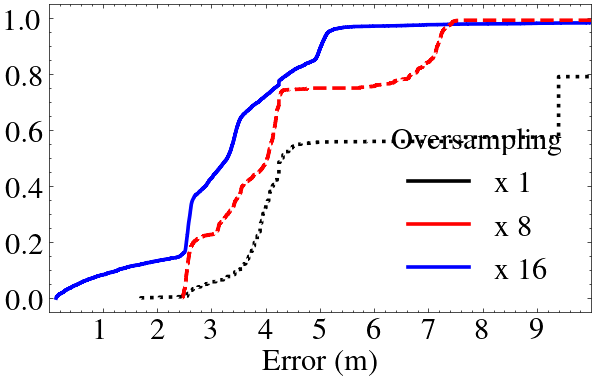

In [15]:
f, ax = plt.subplots(figsize=(7, 4))
plt.rcParams.update({'font.size': 22})

sns.ecdfplot(data=results_df, x='error',hue='Oversampling',linewidth=2.6)
ax.set(xlim=(0, 10),ylim=(-0.05,1.05))
ax.set(xlabel="Error (m)", ylabel = "")
ax.set(xticks=np.arange(1,10),yticks=[0.,.2,.4,.6,.8,1.])

# leg = ax.legend(loc='lower right', ncols=1, frameon=True)
# leg.get_frame().set_edgecolor((.0,.0,.0,.5))
plt.savefig("pics/oversample.pdf", format="pdf", bbox_inches='tight')

In [20]:
data_ecdf = pd.DataFrame(columns=['error','prop','Oversampling'])
for o in oversampling_levels:
    e = np.sort(results_df.loc[results_df['Oversampling'] == f'x {o}',:]['error'].to_numpy())
    ecdf = ECDF(e)
    p = ecdf(e)

    tmp = pd.DataFrame(np.vstack((e,p)).T, columns=['error','prop'])
    tmp['Oversampling'] = f'x {o}'
    l = np.linspace(0,tmp.shape[0]-1,400,endpoint=True)
    tmp = tmp.iloc[l,:]
    data_ecdf = pd.concat((data_ecdf,tmp),ignore_index=True)

In [21]:
ls = np.unique(results_df['Oversampling'].to_numpy())
ls_ordered = ls[[0,2,1]]
ls_ordered

array(['x 1', 'x 8', 'x 16'], dtype=object)

In [22]:
cp=sns.color_palette("tab10", 2)
colorcycler = cycle(cp)
linestyles = ["dashed","dashed","dashdot","dashdot","solid","solid","dotted",]
linecycler = cycle(linestyles)

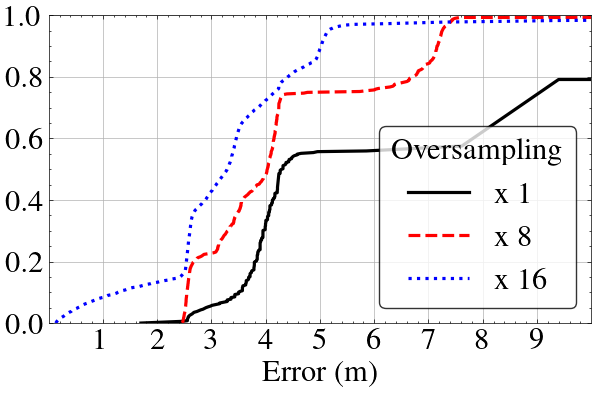

In [27]:
f, ax = plt.subplots(figsize=(7, 4))
plt.rcParams.update({'font.size': 22})

for ls_o in ls_ordered:
    data_to_plot = data_ecdf.loc[data_ecdf['Oversampling'] == ls_o,:]
    x = data_to_plot['error'].to_numpy()
    y = data_to_plot['prop'].to_numpy()

    ax.plot(x,y,linewidth=2.3,label=ls_o)

ax.set(xlim=(0, 10),ylim=(-0.0,1.0))
ax.set(xlabel="Error (m)", ylabel = "")
ax.set(xticks=np.arange(1,10),yticks=[0.,.2,.4,.6,.8,1.])
ax.grid()

leg = ax.legend(title='Oversampling', loc='lower right', ncols=1, frameon=True)
leg.get_frame().set_edgecolor((.0,.0,.0,.5))
plt.savefig("pics/oversample.pdf", format="pdf", bbox_inches='tight')